In [1]:
%load_ext autoreload
%autoreload 2

## Set up project and load data

In [9]:
import Concord as ccd
import scanpy as sc
import torch

from pathlib import Path
import time
proj_name = "pbmc3k"
save_dir = Path(f"../save/{proj_name}_{time.strftime('%b%d')}/")
save_dir.mkdir(parents=True, exist_ok=True)
file_suffix = f"{proj_name}_{time.strftime('%b%d')}"

adata = sc.datasets.pbmc68k_reduced()


In [12]:
adata.shape

(700, 765)

In [14]:
adata.obs

,bulk_labels,n_genes,percent_mito,n_counts,S_score,G2M_score,phase,louvain,log_nGenes
index,,,,,,,,,
AAAGCCTGGCTAAC-1,CD14+ Monocyte,1003,0.023856,2557.0,-0.119160,-0.816889,G1,1,6.910751
AAATTCGATGCACA-1,Dendritic,1080,0.027458,2695.0,0.067026,-0.889498,S,1,6.984716
AACACGTGGTCTTT-1,CD56+ NK,1228,0.016819,3389.0,-0.147977,-0.941749,G1,3,7.113142
AAGTGCACGTGCTA-1,CD4+/CD25 T Reg,1007,0.011797,2204.0,0.065216,1.469291,G2M,9,6.914731
ACACGAACGGAGTG-1,Dendritic,1178,0.017277,3878.0,-0.122974,-0.868185,G1,2,7.071573
...,...,...,...,...,...,...,...,...,...
TGGCACCTCCAACA-8,Dendritic,1166,0.008840,3733.0,-0.124456,-0.867484,G1,2,7.061334
TGTGAGTGCTTTAC-8,Dendritic,1014,0.022068,2311.0,-0.298056,-0.649070,G1,1,6.921658
TGTTACTGGCGATT-8,CD4+/CD25 T Reg,1079,0.012821,3354.0,0.216895,-0.527338,S,0,6.983790


## Standard Scanpy pipeline (PCA -> UMAP)

In [11]:
import scanpy as sc
adata_sc = adata.copy()
# sc.pp.normalize_total(adata_sc, target_sum=1e4)  # Normalize each cell to have the same total count
# sc.pp.log1p(adata_sc)  # Logarithmize the data
# sc.pp.highly_variable_genes(adata_sc, n_top_genes=10000)  # Identify highly variable genes
# sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata_sc, n_neighbors=15)  
sc.tl.umap(adata_sc, min_dist=0.1)
adata.obsm = adata_sc.obsm 

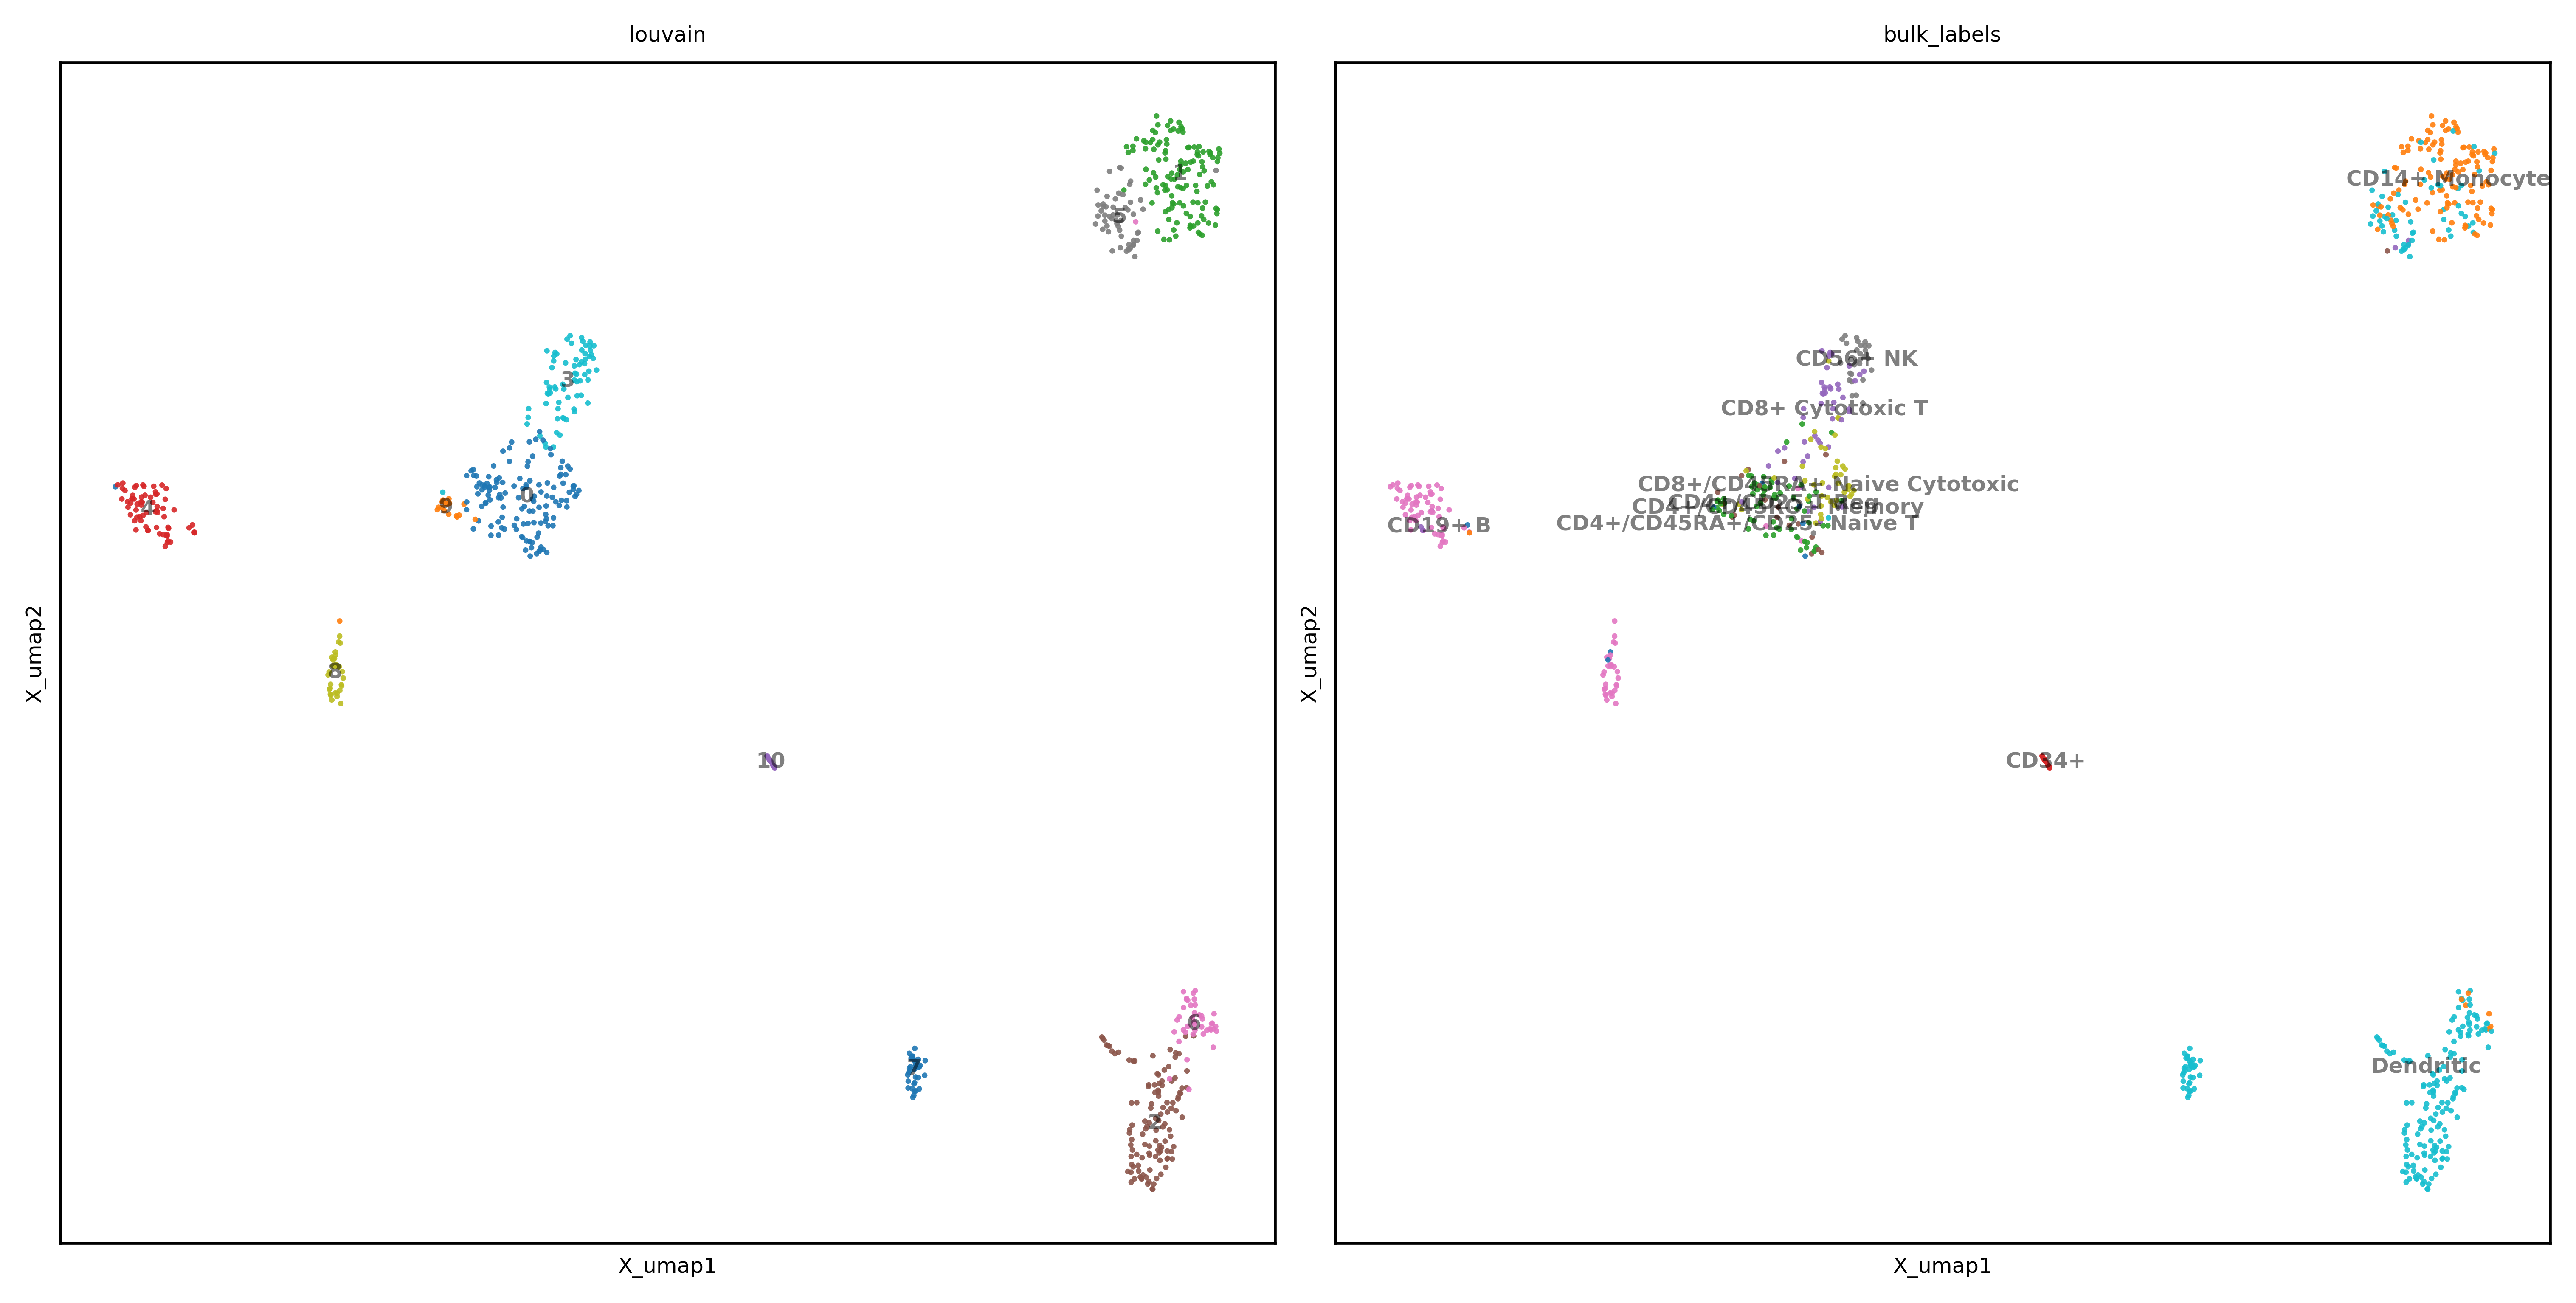

In [16]:
import numpy as np
adata.obs['log_nGenes'] = np.log(adata.obs['n_genes'])
show_basis = 'X_umap'
color_by = ['louvain', 'bulk_labels']
file_suffix = f"{proj_name}_{time.strftime('%b%d-%H%M')}"
ccd.pl.plot_embedding(
    adata, basis=show_basis, color_by=color_by, figsize=(10, 5), dpi=600, ncols=2, font_size=6, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

In [21]:
adata.X

array([[-0.326, -0.191, -0.728, ..., -0.21 , -0.636,  4.011],
       [ 1.171, -0.191,  0.795, ..., -0.21 ,  2.63 , -0.49 ],
       [-0.326, -0.191,  0.483, ..., -0.21 ,  0.663, -0.49 ],
       ...,
       [-0.326, -0.191, -0.728, ..., -0.21 , -0.636,  1.226],
       [-0.326, -0.191, -0.728, ..., -0.21 , -0.636, -0.49 ],
       [-0.326, -0.191,  0.148, ..., -0.21 , -0.636, -0.49 ]],
      dtype=float32)

In [31]:

# Set device to cpu or to gpu (if your torch has been set up correctly to use GPU)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# Select top variably expressed/accessible features for analysis (other methods besides seurat_v3 available)
#feature_list = ccd.ul.select_features(adata, n_top_features=10000, flavor='seurat_v3')

# Initialize Concord with an AnnData object, skip input_feature default to all features
cur_ccd = ccd.Concord(adata=adata, input_feature=None, augmentation_mask_prob=0.2, device=device, seed=1, inplace=False) 
# If integrating data across batch, simply add the domain_key argument
# cur_ccd = ccd.Concord(adata=adata, input_feature=feature_list, domain_key='batch', device=device) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
cur_ccd.encode_adata(input_layer_key='X', output_key='Concord', preprocess=False)
adata.obsm = cur_ccd.adata.obsm # If not inplace

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.


WARNING clustering 700 points to 26 centroids: please provide at least 1014 training points
Epoch 0 Training: 10it [00:00, 51.54it/s, loss=5.21]
Epoch 4 Training: 100%|██████████| 10/10 [00:00<00:00, 80.39it/s, loss=4.83]


In [32]:
adata.obsm['Concord']

array([[-0.16414492, -0.05319611, -0.04299859, ...,  0.19891264,
         0.97995174, -0.1241364 ],
       [-0.18127581, -0.09864487, -0.02366972, ..., -0.03020385,
         2.495944  , -0.03661081],
       [ 1.042599  ,  0.16682284,  0.09915993, ..., -0.09980576,
        -0.12265996,  3.0324008 ],
       ...,
       [ 1.468591  ,  1.1603526 , -0.09731417, ..., -0.0361136 ,
        -0.03366644,  0.13307495],
       [ 0.34182176, -0.06719552,  1.0740259 , ..., -0.05587959,
        -0.14119105,  0.27549127],
       [-0.18705086, -0.07220978,  0.42140946, ...,  1.8365579 ,
         0.38794333, -0.17296153]], dtype=float32)

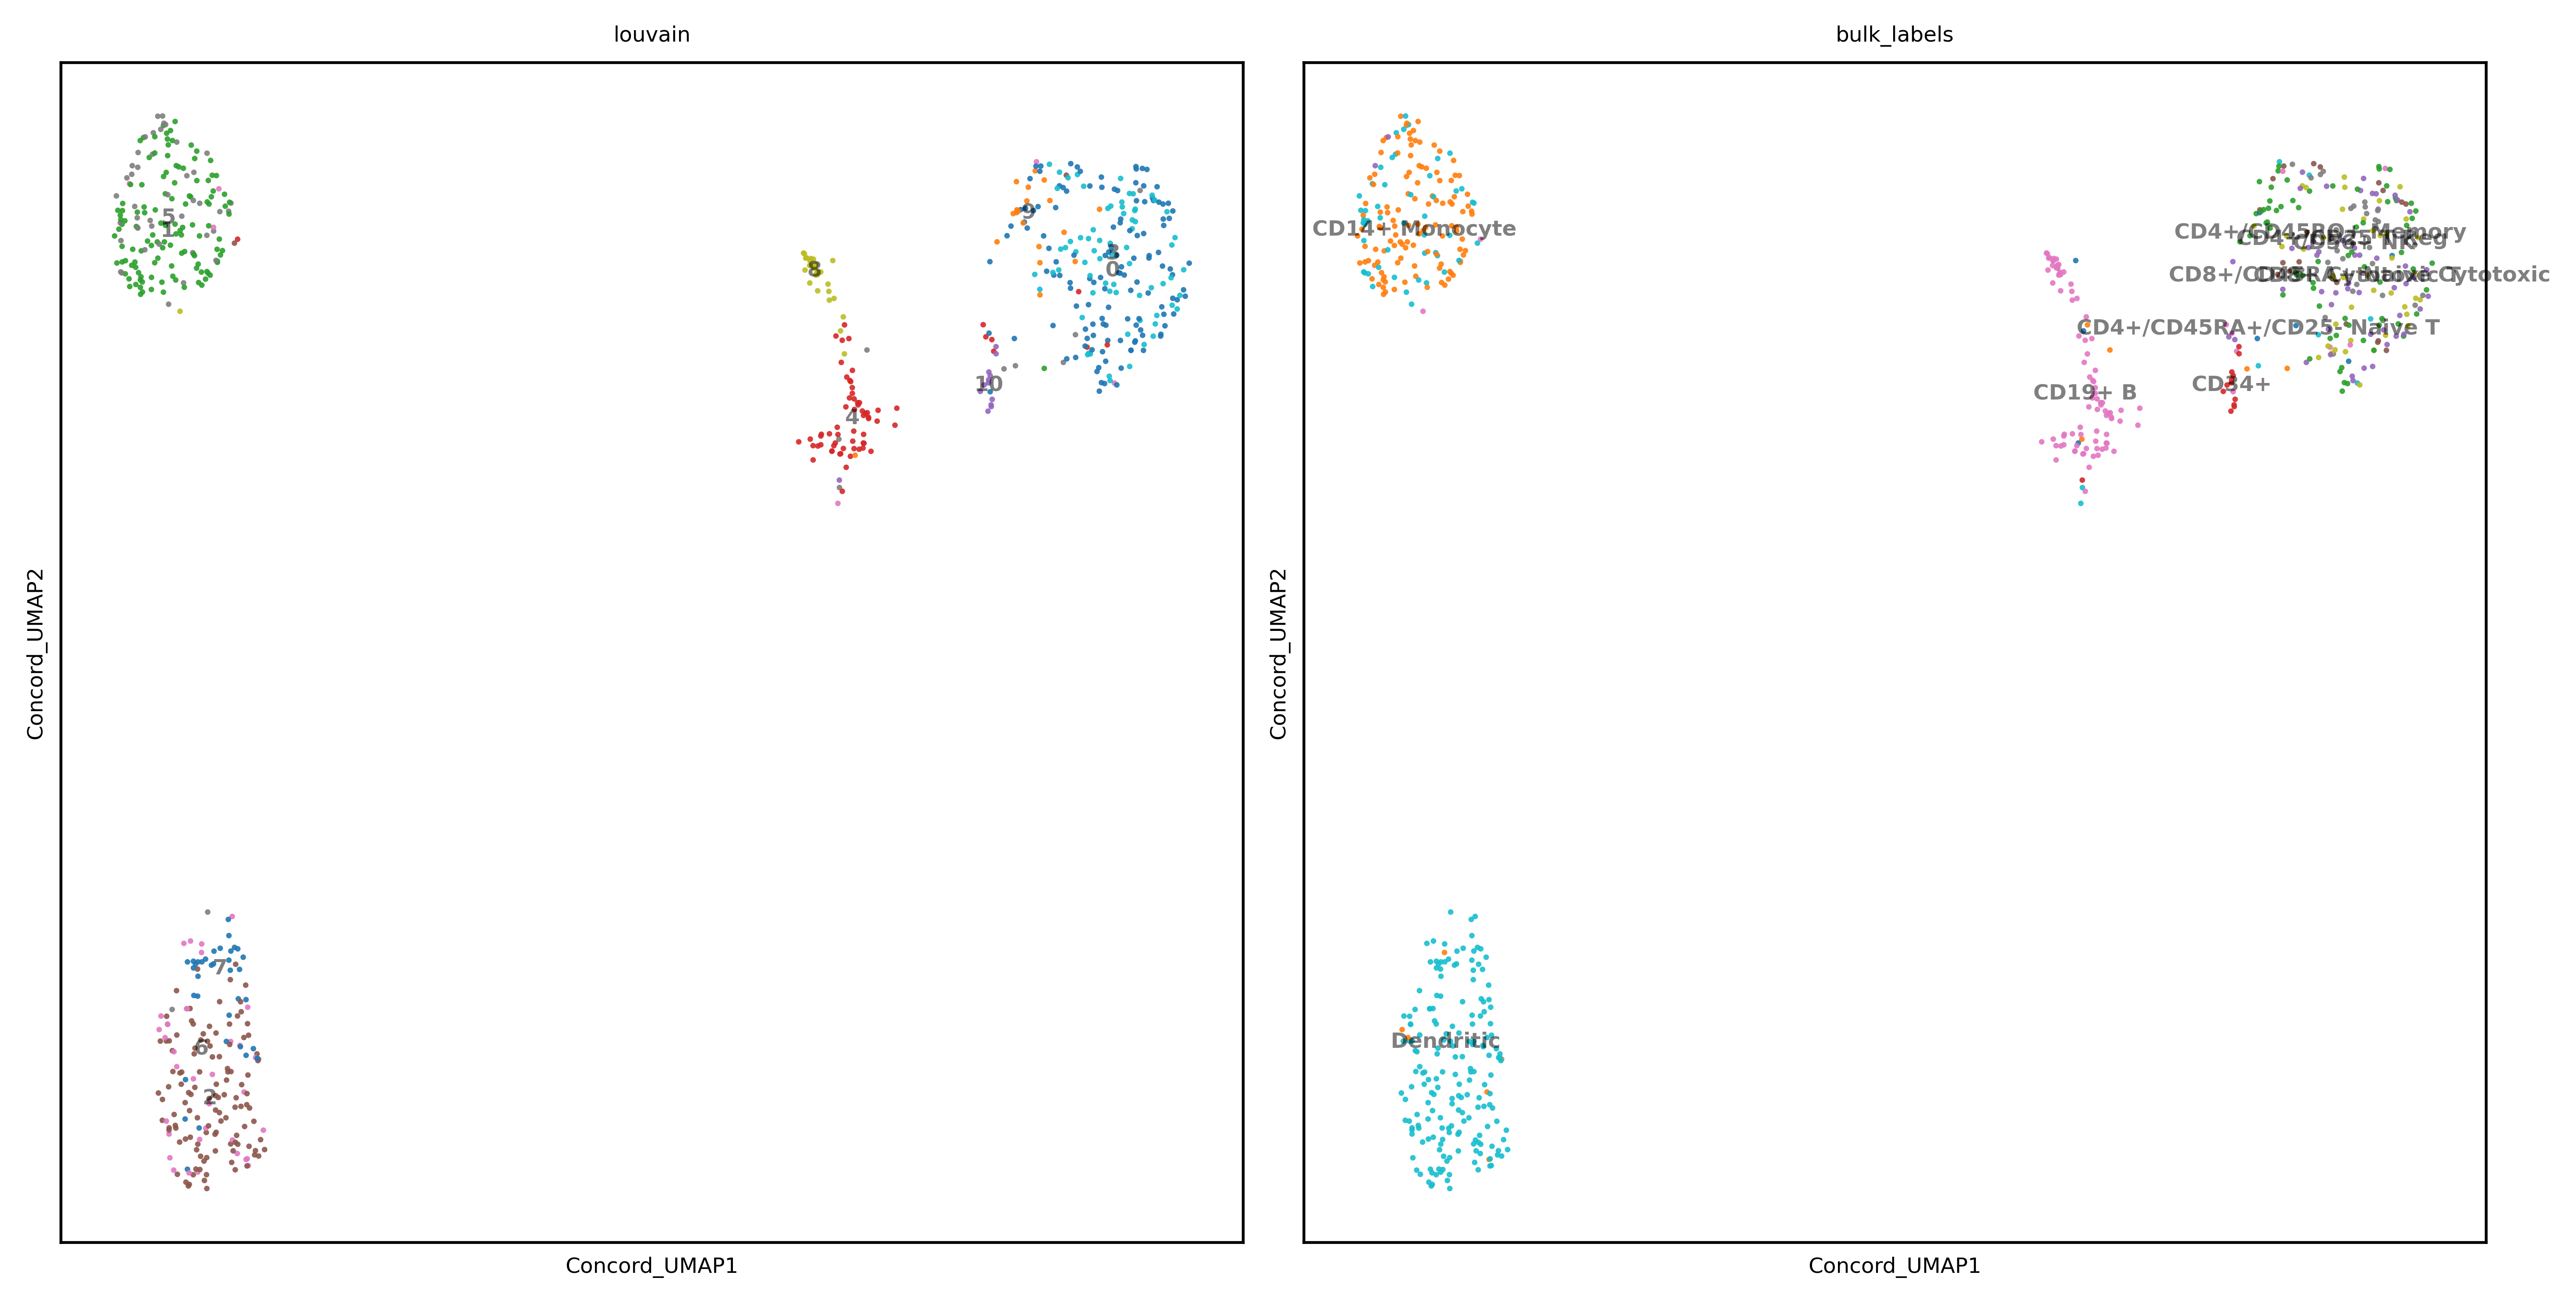

In [33]:
ccd.ul.run_umap(adata, source_key='Concord', umap_key='Concord_UMAP', n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean')
show_basis = 'Concord_UMAP'
color_by = ['louvain', 'bulk_labels']
file_suffix = f"{proj_name}_{time.strftime('%b%d-%H%M')}"
ccd.pl.plot_embedding(
    adata, basis=show_basis, color_by=color_by, figsize=(10, 5), dpi=600, ncols=2, font_size=6, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

In [74]:
ccd.ul.run_umap(adata, source_key='Concord', umap_key='Concord_UMAP_3D', n_components=3, n_neighbors=15, min_dist=0.1, metric='euclidean')

# Plot the 3D UMAP embeddings
col = 'louvain'
ccd.pl.plot_embedding_3d(
    adata, basis='Concord_UMAP_3D', color_by=col,
    save_path='Concord_UMAP_3D.html',
    point_size=1, opacity=0.8, width=1500, height=1000
)

In [13]:

obsm_filename = save_dir / f"obsm_{file_suffix}.h5"
ccd.ul.save_obsm_to_hdf5(adata, obsm_filename)
adata.write_h5ad(save_dir / f"adata_concord_{file_suffix}.h5ad")

In [16]:
ccd.ul.anndata_to_viscello(adata, save_dir / f"cello_{proj_name}_{file_suffix}", project_name = proj_name, organism='hsa')

VisCello project created at ../save/pbmc3k_Oct06/cello_pbmc3k_pbmc3k_Oct06


In [15]:
adata.var_names

Index(['AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9', 'LINC00115', 'NOC2L',
       'PLEKHN1', 'RP11-54O7.17', 'HES4', 'RP11-54O7.11', 'ISG15',
       ...
       'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-ND3', 'MT-ND6', 'MT-CYB',
       'AC145212.1', 'AL592183.1', 'AL354822.1', 'PNRC2-1'],
      dtype='object', name='index', length=10000)